In [1]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [2]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

if not (os.path.isdir(hp.mels_dir)):
    os.mkdir(hp.mels_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mels_dir, hp.mels_dir))
    
if not (os.path.isdir(hp.mags_dir)):
    os.mkdir(hp.mags_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mags_dir, hp.mags_dir))

In [3]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [4]:
fnames, texts, secs, text_lengths = [], [], [], []
char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    encodedText = [char2idx[char] for char in text]
    encodedText = np.array(encodedText, np.int32)#.tostring()
    fnames.append(fname); texts.append(encodedText)
    secs.append(float(sec)); text_lengths.append(len(encodedText))
    
fnames = np.asarray(fnames)
texts = np.asarray(texts)
secs = np.asarray(secs)

100%|█████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 10293.44it/s]


In [5]:
#Random Selection
randIdx = np.random.choice(range(len(lines)), 20)
randIdx.sort()
print(randIdx)

fnames = fnames[randIdx]
texts = texts[randIdx]
secs = secs[randIdx]

[   67   773  1132  2247  2865  3945  5095  5288  6652  7555  7830  8278
  8947  9208 10205 10572 10864 10974 11126 12331]


In [6]:
maxLen, minLen = max(text_lengths), min(text_lengths)

In [7]:
def spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def mel_spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0, n_mels = hp.n_mels)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def true_spectrogram(wav, nsc, nov):
    
    
    S = librosa.core.stft(wav, n_fft=nsc, hop_length=nov)
    Sxx = abs(S)
    dbS = 20 * np.log10(np.maximum(Sxx, hp.eps))
    
    
    return dbS

In [8]:
def learning_rate_decay(init_lr, global_step, warmup_steps=4000.):
    '''Noam scheme from tensor2tensor'''
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

6:58
1/1_0067.wav


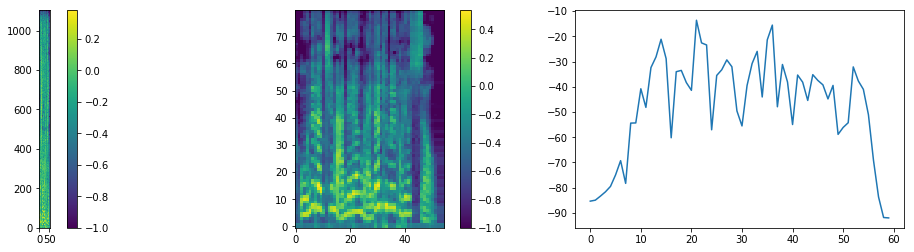

  5%|████▏                                                                              | 1/20 [00:00<00:17,  1.09it/s]

1:64
1/1_0773.wav


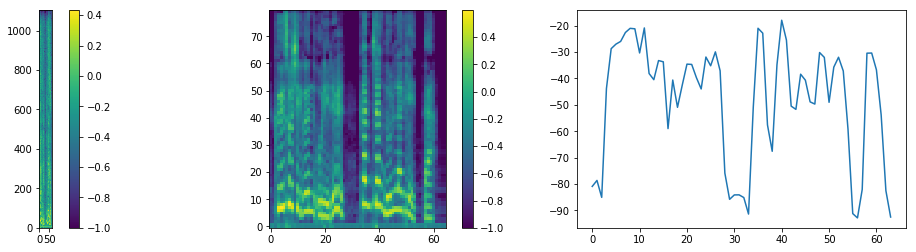

 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.26it/s]

28:60
2/2_0093.wav


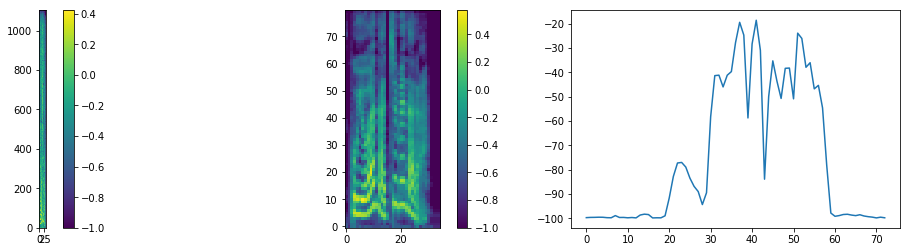

 15%|████████████▍                                                                      | 3/20 [00:01<00:11,  1.43it/s]

11:48
3/3_0051.wav


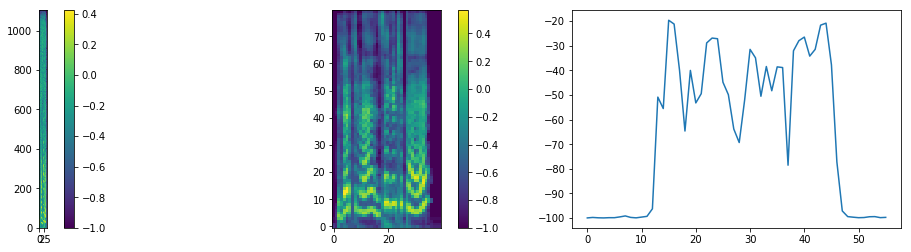

 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.60it/s]

13:65
3/3_0669.wav


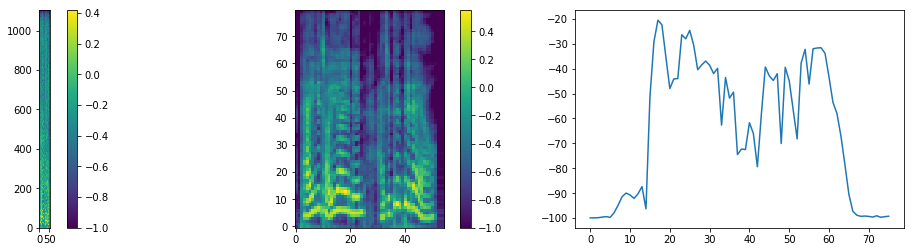

 25%|████████████████████▊                                                              | 5/20 [00:02<00:09,  1.67it/s]

10:62
3/3_1749.wav


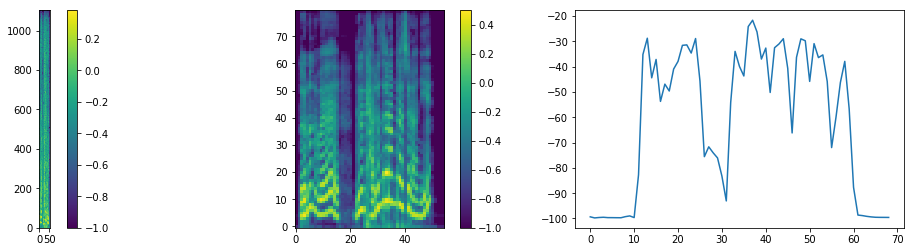

 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.79it/s]

9:95
3/3_2899.wav


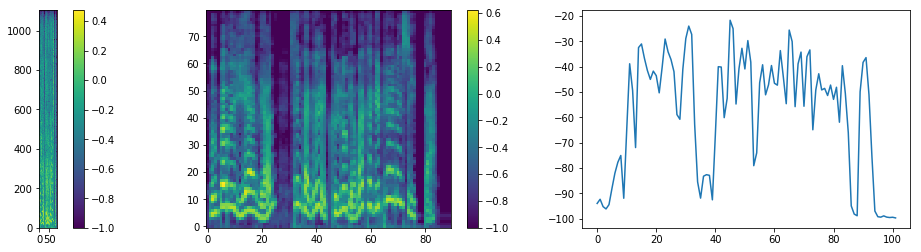

 35%|█████████████████████████████                                                      | 7/20 [00:04<00:07,  1.71it/s]

20:58
3/3_3092.wav


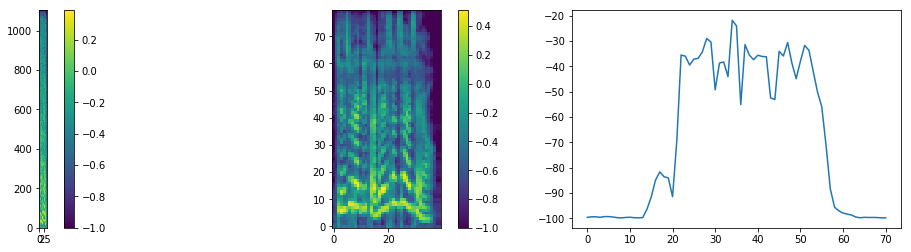

 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.78it/s]

14:49
3/3_4456.wav


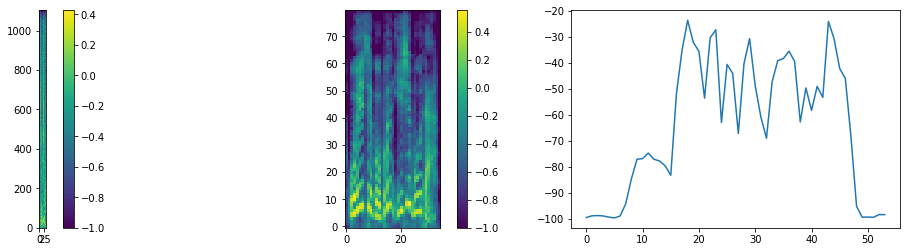

 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.82it/s]

13:42
4/4_0334.wav


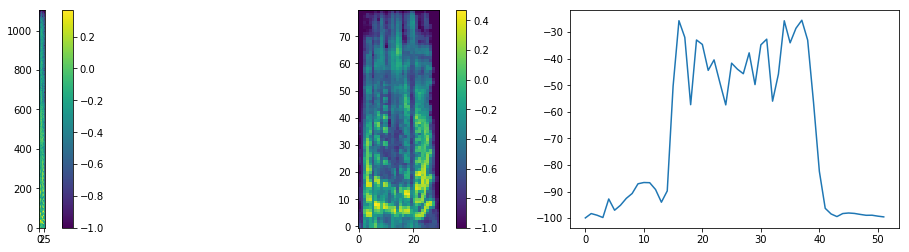

 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.92it/s]

11:53
4/4_0609.wav


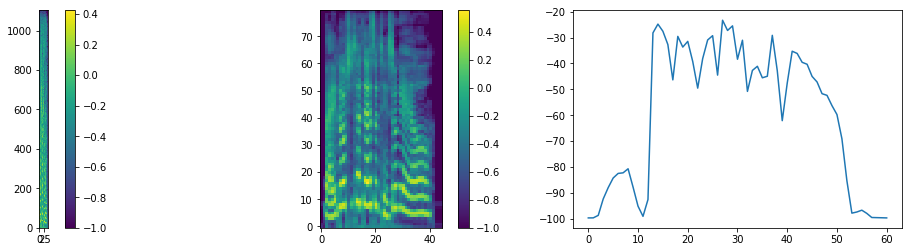

 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:04,  1.91it/s]

13:62
4/4_1057.wav


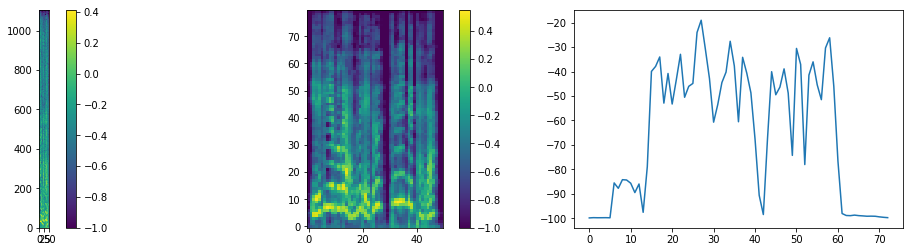

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.97it/s]

14:55
4/4_1726.wav


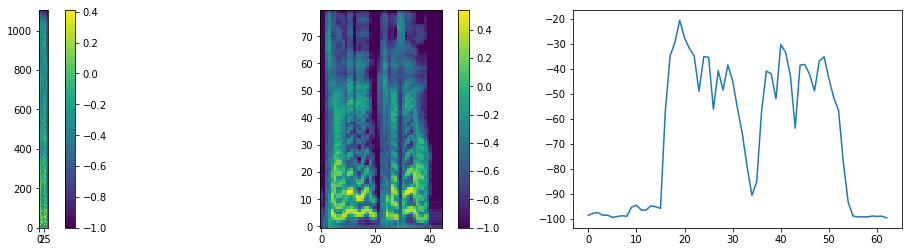

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  2.01it/s]

12:59
4/4_1987.wav


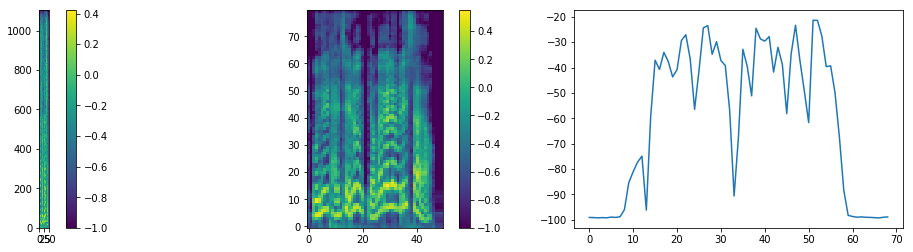

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:02,  2.06it/s]

11:43
4/4_2984.wav


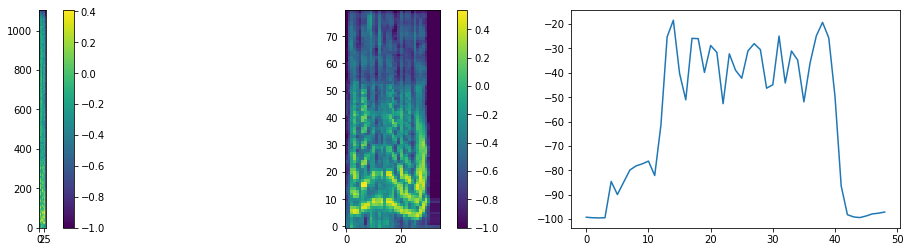

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  2.08it/s]

10:45
4/4_3351.wav


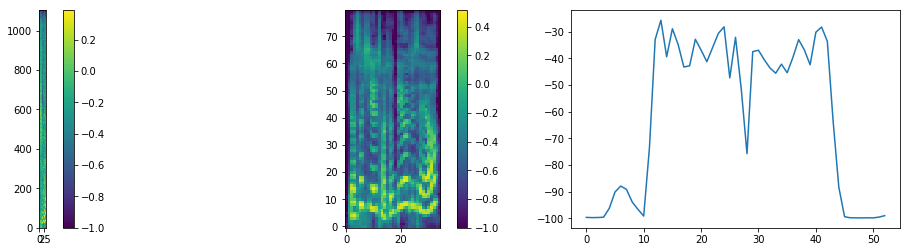

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:01,  2.07it/s]

13:57
4/4_3643.wav


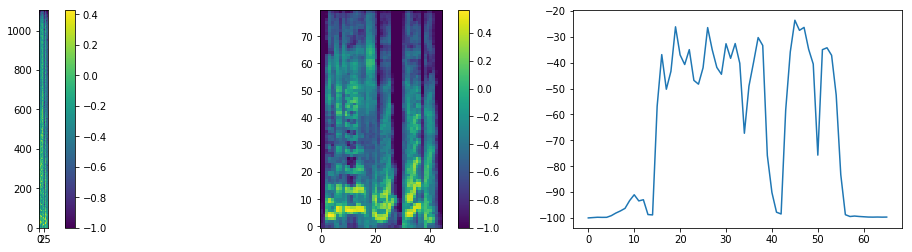

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  2.09it/s]

10:42
4/4_3753.wav


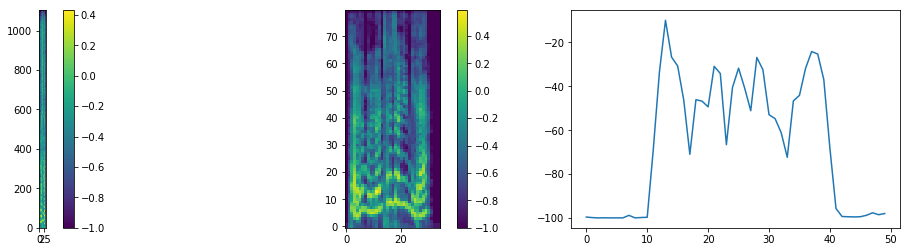

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:00,  2.18it/s]

14:70
4/4_3905.wav


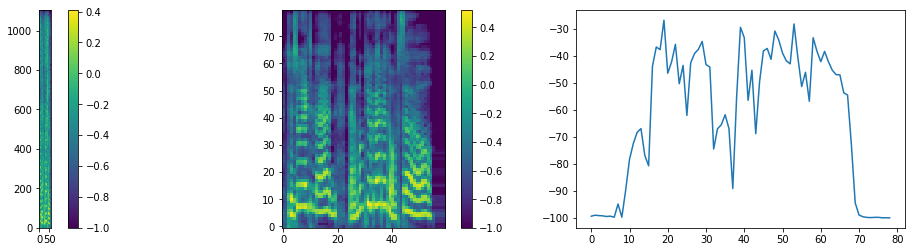

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:09<00:00,  2.15it/s]

13:50
4/4_5110.wav


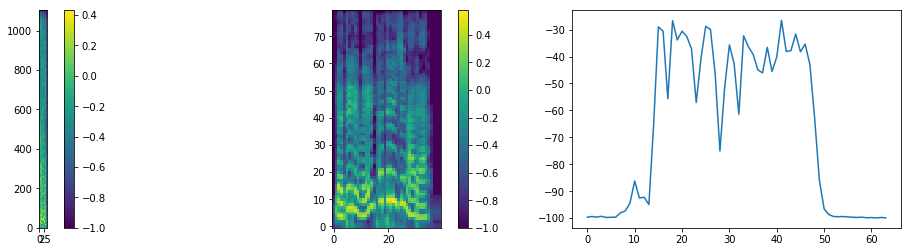

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  2.13it/s]


In [9]:
mels, mags, ys = [], [], []

for i in tqdm(range(0, len(fnames))):
    fname = fnames[i]
    text = texts[i]
    
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
#     if os.path.isfile(mel_path) and os.path.isfile(mag_path):
    if False:
        
        mag = np.load(mag_path)
        mel = np.load(mel_path) 
        
    else :
    
        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag_coef = np.mean(spectrogram(wav, nsc, nov, fs), axis=0)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        mag = true_spectrogram(wav, nsc, nov)
        
        active = np.where(mag_coef > hp.db_limit)[0]
        
        first = active[0]
        last = active[-1] + 1
        
        if first - hp.offset >= 0:
            first = first - hp.offset
        else:
                first = 0
            
        if last + hp.offset < len(mag_coef):
            last = last + hp.offset
        else:
            last = len(mag_coef)
            
        mag = mag[:, first:last]
        mel = mel[:, first:last]
        
        mag = mag / hp.max_db
        mel = mel / hp.max_db
        
        # Do I really need 
        t = mel.shape[1]
        num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # 0 for multiples
        
        mel = np.pad(mel.T, [[0, num_paddings], [0, 0]], mode="minimum")
        mag = np.pad(mag.T, [[0, num_paddings], [0, 0]], mode="minimum")
        
        mel = mel.T
        mag = mag.T
        
        mel = mel.astype(np.float32)
        mag = mag.astype(np.float32) # Default is float64, type crashes at the Attention Wrapper
        
        print('{:d}:{:d}'.format(first, last))
        
        np.save(mag_path, mag)
        np.save(mel_path, mel)
    
    print(fname)
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(mag, origin='lower')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(mel, origin='lower')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.plot(mag_coef)
    plt.show()
    
    ys.append(mel.T.reshape((-1, hp.n_mels*hp.r)))
    mels.append(mel.T[hp.r - 1::hp.r, :]) # Reduce sample size by r
    mags.append(mag.T)

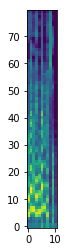

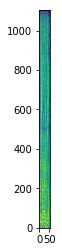

In [10]:
plt.imshow(mels[0].T, origin='lower')
plt.show()
plt.imshow(mags[0].T, origin='lower')
plt.show()

In [11]:
mels[0].shape

(11, 80)

In [12]:
decoder_inputs = []

for i in range(len(mels)):
    mel = mels[i]
    decoder_input = tf.concat((tf.zeros_like(mel[:1, :]), mel[:-1, :]), 0)
    decoder_inputs.append(decoder_input)

In [13]:
sess = tf.InteractiveSession()

In [19]:
sess.run(tf.global_variables_initializer())
x = sess.run(decoder_inputs)
x[16].shape

(9, 80)

In [ ]:
with tf.variable_scope("embedding", reuse=tf.AUTO_REUSE):
    lookup_table = tf.get_variable('lookup_table', 
                                   dtype=tf.float32, 
                                   shape=[len(hp.vocab), hp.embed_size],
                                   initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))

In [ ]:
sess.run(tf.global_variables_initializer())
sess.run(lookup_table)

In [ ]:
embed_texts = []

for i in range(len(texts)):
    text = texts[i]
    embed_text = tf.nn.embedding_lookup(lookup_table, text)
    embed_text = tf.expand_dims(embed_text, 0)
    embed_texts.append(embed_text)

In [ ]:
embed_text

In [ ]:
lookup_table.name

In [ ]:
encodedText

In [ ]:
x = sess.run(embed_texts)

In [ ]:
plt.imshow(x[5][0, :, :])

In [ ]:
prenet_results = []

for i in tqdm(range(len(embed_texts))):
    embed_text = embed_texts[i]
    with tf.variable_scope("prenet", reuse=tf.AUTO_REUSE):
        outputs = tf.layers.dense(embed_text, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
        outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 
        
    prenet_results.append(outputs)
        

In [ ]:
# sess.run(tf.global_variables_initializer())
# x = sess.run(prenet_results)

In [ ]:
# for i in tqdm(range(len(embed_texts))):
conv_bank_results = []

for i in tqdm(range(len(prenet_results))):
    with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
        prenet_result = prenet_results[i]

        for k in range(1, hp.K + 1):
            with tf.variable_scope("filter_num_{}".format(k)):
                params = {"inputs":prenet_result, "filters":hp.num_k_filter, "kernel_size":k,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}
                
                # Works when resue = True
                # For i loop, filter is reused.

                conv_outputs = tf.layers.conv1d(**params)
                if k == 1:
                    conv_bank_outputs = conv_outputs
                else:
                    conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)
                
    conv_bank_results.append(conv_bank_outputs)
                
#     print(prenet_outputs)


In [ ]:
sess.run(tf.global_variables_initializer())
sess.run(conv_bank_results)

In [ ]:
max_pooling_results = [];

for i in tqdm(range(len(conv_bank_results))):
    conv_bank_result = conv_bank_results[i]

    max_pooled = tf.layers.max_pooling1d(conv_bank_result, pool_size=2, strides=1, padding="same")
                
    max_pooling_results.append(max_pooled)
    

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(max_pooling_results)

In [ ]:
x[0].shape
conv_bank_results[0].shape

In [ ]:
conv_proj_1_results = []

with tf.variable_scope("conv1d_1"):
    for i in tqdm(range(len(max_pooling_results))):
        max_pooling_result = max_pooling_results[i]
        
        params = {"inputs":max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        conv_proj_1_result = tf.layers.conv1d(**params)

        conv_proj_1_results.append(conv_proj_1_result)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(conv_proj_1_results)

In [ ]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
# plt.clim([-0.4, 0.4])

In [ ]:
batch_norm_1_results = []

with tf.variable_scope("conv1d_1"):
    for i in tqdm(range(len(conv_proj_1_results))):
        conv_proj_1_result = conv_proj_1_results[i]

        bn_1_result = tf.contrib.layers.batch_norm(inputs=conv_proj_1_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_1",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        bn_1_act = tf.nn.relu(bn_1_result)
        
        batch_norm_1_results.append(bn_1_act)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(batch_norm_1_results)

In [ ]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.clim([-0.4, 0.4])

In [ ]:
conv_proj_2_results = []

with tf.variable_scope("conv1d_2"):
    for i in tqdm(range(len(batch_norm_1_results))):
        batch_norm_1_result = batch_norm_1_results[i]
        
        params = {"inputs":batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        conv_proj_2_result = tf.layers.conv1d(**params)

        conv_proj_2_results.append(conv_proj_2_result)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(conv_proj_2_results)

In [ ]:
plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.clim([-0.4, 0.4])

In [ ]:
batch_norm_2_results = []

with tf.variable_scope("conv1d_2"):
    for i in tqdm(range(len(conv_proj_2_results))):
        conv_proj_2_result = conv_proj_2_results[i]

        bn_2_result = tf.contrib.layers.batch_norm(inputs=conv_proj_2_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_2",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        bn_2_act = tf.nn.relu(bn_2_result)
        
        batch_norm_2_results.append(bn_2_act)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(batch_norm_2_results)

plt.imshow(x[0][0, :, :])
plt.colorbar()

In [ ]:
batch_norm_2_results

In [ ]:
from operator import add
res_outputs = list(map(add, prenet_results, batch_norm_2_results))

In [ ]:
plt.imshow(sess.run(prenet_results[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(batch_norm_2_results[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(res_outputs[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(sess.run(res_outputs[0][0, :, :] - batch_norm_2_results[0][0, :, :]))
plt.colorbar()
plt.show()

In [ ]:
for i in range(hp.num_highwaynet_blocks):
    scope = "highwaynet_{:d}".format(i)
    with tf.variable_scope(scope):
        
        if i == 0:
            highwaynet_inputs = res_outputs
        else:
            highwaynet_inputs = highwaynet_outputs
        
        highwaynet_outputs = []
            
        for j in range(len(highwaynet_inputs)):
            highwaynet_input = highwaynet_inputs[j]
            
            H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
            T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
            highwaynet_output = H*T + highwaynet_input*(1.-T)
            
            highwaynet_outputs.append(highwaynet_output)
            
    

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(highwaynet_outputs)

In [ ]:
plt.imshow(sess.run(res_outputs[0][0, :, :]))
plt.colorbar()
plt.show()

plt.imshow(x[0][0, :, :])
plt.colorbar()
plt.show()

In [ ]:
gru_results = []
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
    for i in range(len(highwaynet_outputs)):
#     cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
#     cell_bw = tf.contrib.rnn.GRUCell(hp.num_gru_units)
        cell = tf.contrib.rnn.GRUCell(128)
        cell_bw = tf.contrib.rnn.GRUCell(128)

        highwaynet_output = highwaynet_outputs[i]
        
        output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
        output = tf.concat(output, 2)
        
        gru_results.append(output)
    

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(gru_results)

In [ ]:
decoder_prenet_results = []

for i in tqdm(range(len(decoder_inputs))):
    decoder_input = decoder_inputs[i]
    with tf.variable_scope("decoder_prenet", reuse=tf.AUTO_REUSE):
        outputs = tf.layers.dense(decoder_input, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
        outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
        outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 
        
    decoder_prenet_results.append(outputs)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(decoder_prenet_results)

In [ ]:
plt.imshow(x[0])

In [ ]:
decs, states = [], []

with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    for i in range(len(gru_results)):
        gru_result = gru_results[i]
        decoder_prenet_result = tf.expand_dims(decoder_prenet_results[i], 0)
        
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(hp.num_attention_units, gru_result)
        decoder_cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
        cell_with_attention = tf.contrib.seq2seq.AttentionWrapper(decoder_cell,
                                                                  attention_mechanism,
                                                                  hp.num_attention_units,
                                                                  alignment_history=True)
        dec, state = tf.nn.dynamic_rnn(cell_with_attention, decoder_prenet_result, dtype=tf.float32)
        
        decs.append(dec)
        states.append(state)


In [ ]:
# sess.run(states)
# Error occurs if you tries to run states 

In [ ]:
y_hats, alignments = [], []
    
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    for i in range(len(states)):
        state = states[i]
        dec = decs[i]

        alignment = tf.transpose(state.alignment_history.stack(),[1,2,0])
        
        with tf.variable_scope("decoder_gru_1", reuse=tf.AUTO_REUSE):
            cell = tf.contrib.rnn.GRUCell(128)
            output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
            gru_output_1 = tf.concat(output, 2)
            
        dec = dec + gru_output_1

        with tf.variable_scope("decoder_gru_2", reuse=tf.AUTO_REUSE):
            cell = tf.contrib.rnn.GRUCell(128)
            output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
            gru_output_2 = tf.concat(output, 2)
            
        dec = dec + gru_output_2

        # Outputs => (N, T_y/r, n_mels*r)
        y_hat = tf.layers.dense(dec, hp.n_mels*hp.r)
        
        y_hats.append(y_hat)
        alignments.append(alignment)

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(y_hats)

In [ ]:
yy = sess.run(alignments)
y_hat = y_hats[i]
dec_2_reshape = tf.reshape(y_hat, [1, -1, hp.n_mels])

In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(dec_2_reshape)

In [ ]:
plt.imshow(x[0])

In [ ]:
dec_2_inputs = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(len(y_hats)):
        y_hat = y_hats[i]
        dec_2_input = tf.reshape(y_hat, [1, -1, hp.n_mels])
        
        dec_2_inputs.append(dec_2_input)

In [ ]:
dec_2_conv_bank_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in tqdm(range(len(dec_2_inputs))):
        with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
            dec_2_input = dec_2_inputs[i]

            for k in range(1, hp.K + 1):
                with tf.variable_scope("filter_num_{}".format(k)):
                    params = {"inputs":dec_2_input, "filters":hp.num_k_filter, "kernel_size":k,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

                    # Works when resue = True
                    # For i loop, filter is reused.

                    conv_outputs = tf.layers.conv1d(**params)
                    if k == 1:
                        conv_bank_outputs = conv_outputs
                    else:
                        conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

        dec_2_conv_bank_results.append(conv_bank_outputs)


In [ ]:
sess.run(tf.global_variables_initializer())
x = sess.run(dec_2_conv_bank_results)

In [ ]:
x[0].shape

In [ ]:
dec_2_max_pooling_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in tqdm(range(len(dec_2_inputs))):
        dec_2_conv_bank_result = dec_2_conv_bank_results[i]

        max_pooled = tf.layers.max_pooling1d(dec_2_conv_bank_result, pool_size=2, strides=1, padding="same")

        dec_2_max_pooling_results.append(max_pooled)

In [ ]:
dec_2_conv_proj_1_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        for i in tqdm(range(len(dec_2_max_pooling_results))):
            dec_2_max_pooling_result = dec_2_max_pooling_results[i]

            params = {"inputs":dec_2_max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

            dec_2_conv_proj_1_result = tf.layers.conv1d(**params)

            dec_2_conv_proj_1_results.append(dec_2_conv_proj_1_result)

In [ ]:
dec_2_batch_norm_1_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        for i in tqdm(range(len(dec_2_conv_proj_1_results))):
            dec_2_conv_proj_1_result = dec_2_conv_proj_1_results[i]

            bn_1_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_1_result,
                                                   center=True,
                                                   scale=True,
                                                   updates_collections=None,
                                                   is_training=True,
                                                   scope="conv1d_1",
                                                   fused=True,
                                                   reuse=tf.AUTO_REUSE)
            bn_1_act = tf.nn.relu(bn_1_result)

            dec_2_batch_norm_1_results.append(bn_1_act)

In [ ]:
dec_2_conv_proj_2_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        for i in tqdm(range(len(dec_2_batch_norm_1_results))):
            dec_2_batch_norm_1_result = dec_2_batch_norm_1_results[i]

            params = {"inputs":dec_2_batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                            "dilation_rate":1, "padding":"SAME", "activation":None, 
                            "use_bias":False, "reuse":tf.AUTO_REUSE}

            dec_2_conv_proj_2_result = tf.layers.conv1d(**params)

            dec_2_conv_proj_2_results.append(dec_2_conv_proj_2_result)

In [ ]:
dec_2_batch_norm_2_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        for i in tqdm(range(len(dec_2_conv_proj_2_results))):
            dec_2_conv_proj_2_result = dec_2_conv_proj_2_results[i]

            bn_2_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_2_result,
                                                   center=True,
                                                   scale=True,
                                                   updates_collections=None,
                                                   is_training=True,
                                                   scope="conv1d_2",
                                                   fused=True,
                                                   reuse=tf.AUTO_REUSE)
            bn_2_act = tf.nn.relu(bn_2_result)
            dec_2_batch_norm_2_results.append(bn_2_act)

In [ ]:
dec_2_sync_results = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
        for i in tqdm(range(len(dec_2_batch_norm_2_results))):
            dec_2_batch_norm_2_result = dec_2_batch_norm_2_results[i]

            dec_2_sync_result = tf.layers.dense(dec_2_batch_norm_2_result, 128)
            dec_2_sync_results.append(dec_2_sync_result)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(hp.num_highwaynet_blocks):
        scope = "highwaynet_{:d}".format(i)
        with tf.variable_scope(scope):

            if i == 0:
                highwaynet_inputs = dec_2_sync_results
            else:
                highwaynet_inputs = highwaynet_outputs

            highwaynet_outputs = []

            for j in range(len(highwaynet_inputs)):
                highwaynet_input = highwaynet_inputs[j]

                H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
                T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                    bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
                highwaynet_output = H*T + highwaynet_input*(1.-T)

                highwaynet_outputs.append(highwaynet_output)

In [ ]:
dec_2_gru_results = []
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
    for i in range(len(highwaynet_outputs)):
        cell = tf.contrib.rnn.GRUCell(128)
        cell_bw = tf.contrib.rnn.GRUCell(128)

        highwaynet_output = highwaynet_outputs[i]
        
        output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
        output = tf.concat(output, 2)
        
        dec_2_gru_results.append(output)

In [ ]:
z_hats = []

with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("final", reuse=tf.AUTO_REUSE):
        for i in tqdm(range(len(dec_2_gru_results))):
            dec_2_gru_result = dec_2_gru_results[i]

            dec_2_result = tf.layers.dense(dec_2_gru_result, 1 + hp.nsc_sec*fs//2)
            z_hats.append(dec_2_result)

In [ ]:
z_hats

In [ ]:
mags[0].shape

In [ ]:
z_hats[0].shape

In [ ]:
y_hats[0].shape

In [ ]:
ys[0].shape

In [ ]:
delta_y = lambda y_hat, y: y_hat - y, y_hats, ys

In [ ]:
delta_ys = []

for i in range(len(y_hats)):
    delta_y = abs(y_hats[i][0, :, :] - ys[i])
    delta_ys.append(tf.reduce_mean(delta_y))
    
delta_zs = []

for i in range(len(z_hats)):
    delta_z = abs(z_hats[i][0, :, :] - mags[i])
    delta_zs.append(tf.reduce_mean(delta_z))

In [ ]:
delta_ys

In [ ]:
loss1 = tf.reduce_mean(delta_ys)
loss2 = tf.reduce_mean(delta_zs)
loss = loss1 + loss2

In [ ]:
hp.lr = 0.001

In [ ]:
global_step = tf.Variable(0, name='global_step', trainable=False)
lr = learning_rate_decay(hp.lr, global_step=global_step)
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr)

## gradient clipping
gvs = optimizer.compute_gradients(loss)
clipped = []

for grad, var in gvs:
    grad = tf.clip_by_norm(grad, 5.)
    clipped.append((grad, var))
    
train_op = optimizer.apply_gradients(clipped, global_step=global_step)

In [ ]:
sess.run(tf.global_variables_initializer())
sess.run([train_op, global_step])